理清楚了, 好的回答又出来了, 离谱

> When you write a C app on Linux, you include headers from `glibc` to use the standard functions like malloc, fork etc. When you compile your app, you either compile it statically or dynamically. When you compile it statically, you include all the kernel code in the executable like mmap's code. Basically, when mmap is called from your main function, the CPU jumps to the function which is mapped in virtual memory. Where it "stops" including the code, is when you jump to kernel code using int 0x80 on older x86 32 bits processors. When you link dynamically, it is the same except linking happens just before runtime.

https://stackoverflow.com/a/66827396/16317008

# 1. ISO and Standards

一个重要的组织 ISO, 不是IOS: The International Organization for Standardization

你要捋清ISO, standards和standard library的关系(ISO出版standards, standard包括standard library), ISO每年discuss然后得出语言的standards, C99, C11 standards也就是这么来的, standards主要介绍了两部分内容, 语言本身功能和该语言的standard library. 对, 只是介绍, 剩下的实现由其他人完成(glibc, MSVCRT是c standard library的实现).

C标准库的同义词: **C Standard Library** = **ISO C Library**, (注意这只是介绍, glibc, MSVCRT才是他们的实现, 超集).

比如99年他们讨论的结果就是这个C99 standard: [ISO/IEC 9899:1999(E) -- Programming Languages -- C](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjo5rzimd_6AhVIa94KHe1PDMsQFnoECCMQAQ&url=https%3A%2F%2Fwww.dii.uchile.cl%2F~daespino%2Ffiles%2FIso_C_1999_definition.pdf&usg=AOvVaw1MPepaWR9aWSbzO1gNwbST)), C99 standard内容包括两部分:

- the C/C++ features and functionalities;

- the C/C++ API — a collection of classes, functions and macros that developers use in their C/C++ programs. It is called the **Standard Library**.

---

# 2. Implementation of Standard Library

我们知道C有个分配内存的函数, 还有创建线程, 输入输出(`stdio.h`), 这些都必须依赖system call. 所以第三方厂商实现standard library的时候, 要根据不同的OS来实现不同版本, 毕竟它们有不同的system call.

## 2.1. GNU/Linux implementation

**The GNU C Library**和**glibc**是同义词, 是C的runtime library也是standard library.

其实这个概念有必要澄清一下: runtime library包括static library, daynamic library. runtime library更像是个泛指. 然后printf和math等函数声明在头文件中, 具体实现就在静态库`.a`文件中(`libc.a`是由多个`.o`目标文件压缩得到的), 然后`标准头文件 + 对应实现 = standard library`. 所以, static library 和 standard library(glibc), ummm, 你自己品吧. 

严格来说library和header不是一个东西, library是目标文件, header就是.h文件. 但是我们都说standard library包括包括printf等函数, 然后这些函数又被声明在这些标准头文件中. **所以这个library, 不用非要钻, 知道编译的过程不就行了吗?** 重要的是分清楚静态动态库的优缺点和编译的过程,尤其是链接的过程.

标准库为你写代码提供一些现成的方法、宏等使用，这些方法被封装在动态链接库或静态链接库或直接在头文件里，然后由头文件声明供程序员使用。

MacOS下c的头文件位置: `/Library/Developer/CommandLineTools/SDKs/MacOSX12.3.sdk/usr/include`


## 2.2. Mac and iOS Implementation

On Mac and iOS the C Standard Library implementation is part of `libSystem`, a core library located in `/usr/lib/libSystem.dylib`. LibSystem includes other components such as the math library, the thread library and other low-level utilities. 注意我查了一下, mac上的C标准库好像不在说的这个文件夹了, 有人说在`/usr/lib/system/`我看了下, 立main确实有文件,但不知道是不是他们实现的C标准库.

## 2.3. Windows Implementation

On Windows the implementation of the Standard Libraries has always been strictly bound to **Visual Studio**, the official Microsoft compiler. They use to call it **C/C++ Run-time Library** (CRT) and it covers both implementations.

好文章: https://www.internalpointers.com/post/c-c-standard-library

---

# 3. Static Library and Dynamic Library

Shared libraries(dynamic library) are`.so` (or in Windows `.dll`, or in OS X `.dylib`) files. All the code relating to the library is in this file, and it is referenced by programs using it at run-time. A program using a shared library only makes reference to the code that it uses in the shared library.

Static libraries are `.a` (or in Windows `.lib`) files. All the code relating to the library is in this file, and it is directly linked into the program at compile time. A program using a static library takes copies of the code that it uses from the static library and makes it part of the program.

[两种库的优缺点](https://stackoverflow.com/a/2649430/16317008)

在这就好好讲一下`libc.a`文件:

> 源代码经过预处理, 编译, 汇编后编程一个`.o`目标文件, 这个目标文件需要和其他libraries(`libc.a`是由多个`.o`目标文件压缩得到的)进行最后一步 链接 才能得到最终的可执行文件. 

Linux下, 人们用`ar`程序把很多目标文件压缩到了静态库`libc.a`(glibc的c标准库), 比如输入输出有printf.o，scanf.o；文件操作有fread.o，fwrite.o；时间日期有date.o，time.o；内存管理有malloc.o等。

为什么静态运行库里面一个目标文件只包含一个函数？比如libc.a里面printf.o只有printf()函数、strlen.o只有strlen()函数，为什么要这样组织？

链接器在链接静态库的时候是以目标文件为单位的。比如我们引用了静态库中的printf()函数，那么链接器就只会把库中包含printf()函数的那个目标文件链接进来，由于运行库有成百上千个函数，如果把这些函数都放在一个目标文件中...

如果把整个链接过程比作一台计算机，那么`ld`链接器就是计算机的CPU，所有的目标文件、库文件就是输入，链接结果输出的可执行文件就是输出，而链接控制脚本正是这台计算机的“程序”，它控制CPU的运行，以“程序”要求的方式将输入加工成所须要的输出结果. 

---

# 4. 总结

程序如何使用操作系统提供的API(system call)? 在一般的情况下，一种语言的开发环境往往会附带有语言库（Language Library也可以说是标准库,运行时库）。这些库就是对操作系统的API的包装，比如我们经典的C语言版“Hello World”程序，它使用C语言标准库的“printf”函数来输出一个字符串，“printf”函数对字符串进行一些必要的处理以后，最后会调用操作系统提供的API。各个操作系统下，往终端输出字符串的API都不一样，在Linux下，它是一个“write”的系统调用，而在Windows下它是“WriteConsole”系统API。**标准库函数(运行库)依赖的是system call**。库里面还带有那些很常用的函数，比如C语言标准库里面有很常用一个函数取得一个字符串的长度叫strlen()，该函数即遍历整个字符串后返回字符串长度，这个函数并没有调用任何操作系统的API，也没有做任何输入输出。但是很大一部分库函数(运行库)都是要调用操作系统的API的.

> “Any problem in computer science can be solved by another layer of indirection.”

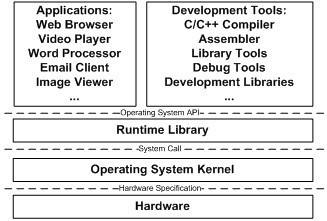

每个层次之间都须要相互通信，既然须要通信就必须有一个通信的协议，我们一般将其称为接口（Interface），接口的下面那层是接口的提供者，由它定义接口；接口的上面那层是接口的使用者，它使用该接口来实现所需要的功能. 

> 运行时库(标准库, static library, dynamic library) 依赖 system call, 它提供头文件(`stdio.h`, `math.h`)供我们使用. 所以它很重要, 它在应用层和操作系统中间. 我们使用它提供的接口(`printf()`)和操作系统进行交流(通过system call).

我们的软件体系中，位于最上层的是应用程序，比如我们平时用到的网络浏览器、Email客户端、多媒体播放器、图片浏览器等。从整个层次结构上来看，开发工具与应用程序是属于同一个层次的，因为它们都使用一个接口，那就是操作系统应用程序编程接口（Application Programming Interface, 就是标准库的头文件）。应用程序接口(头文件)的提供者是运行库，什么样的运行库提供什么样的API，比如Linux下的Glibc库提供POSIX的API；Windows的运行库提供Windows API，最常见的32位Windows提供的API又被称为Win32。

运行库使用操作系统提供的系统调用接口（System call Interface），系统调用接口在实现中往往以软件中断（Software Interrupt）的方式提供，比如Linux使用0x80号中断作为系统调用接口，Windows使用0x2E号中断作为系统调用接口（从Windows XP Sp2开始，Windows开始采用一种新的系统调用方式）。

操作系统内核层对于硬件层来说是硬件接口的使用者，而硬件是接口的定义者，硬件的接口定义决定了操作系统内核，具体来讲就是驱动程序如何操作硬件，如何与硬件进行通信。这种接口往往被叫做硬件规格（Hardware Specification），硬件的生产厂商负责提供硬件规格，操作系统和驱动程序的开发者通过阅读硬件规格文档所规定的各种硬件编程接口标准来编写操作系统和驱动程序。